Planted Motif (Consensus): GTTACCGTGACAGCA
Motifs Found by Gibbs Sampling:
TAACCGTGCTAGCAA
TGACCGTAACCGCAG
TTTCCGCGACCTCAC
ATACCATAATAGCAC
TTGCCGGAAAAGCAA
TTACGGTGTCAGCGA
TAACTGTAAGAGCAG
TTACCCTCAGGGCAA
CAACCGTGATAGCAA
TGAGCGTGACTGTAA
Final Score: 40

Consensus Found: TTACCGTGACAGCAA
Planted Motif:    GTTACCGTGACAGCA
Hamming Distance: 12
Accuracy: 20.00%
Recall:   70.00%


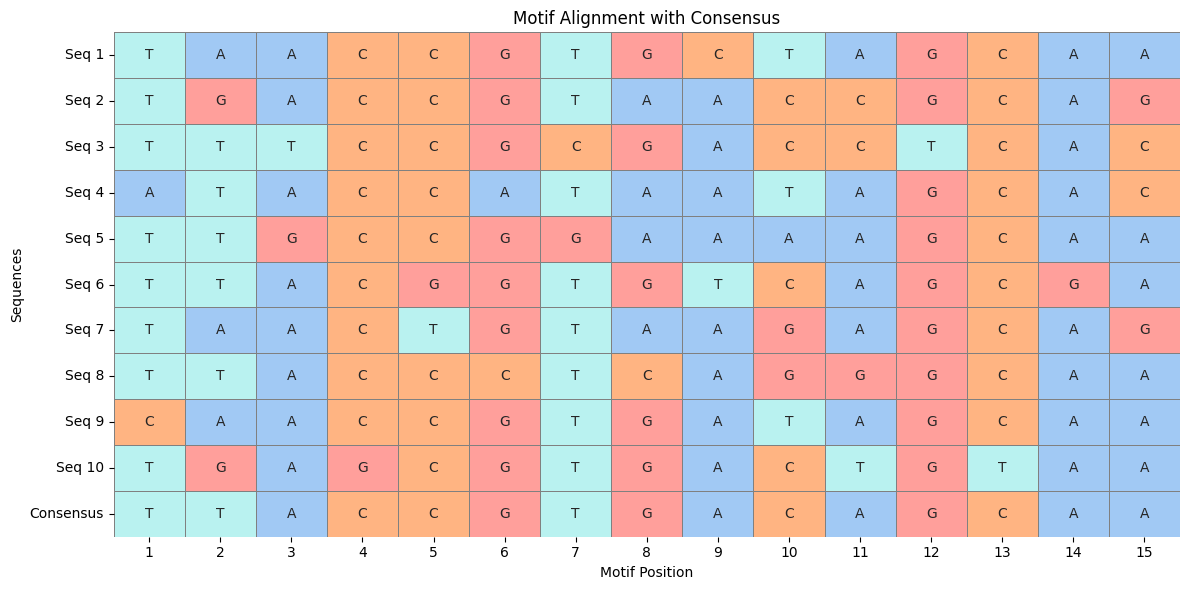

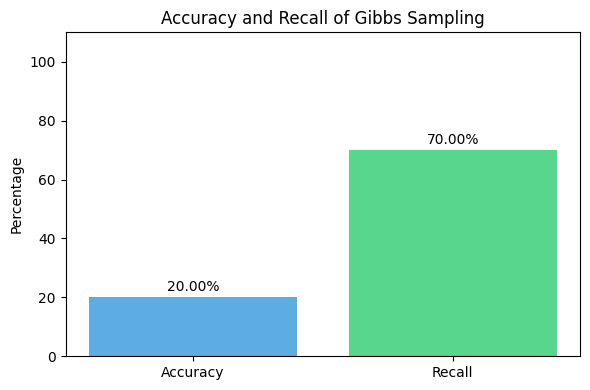

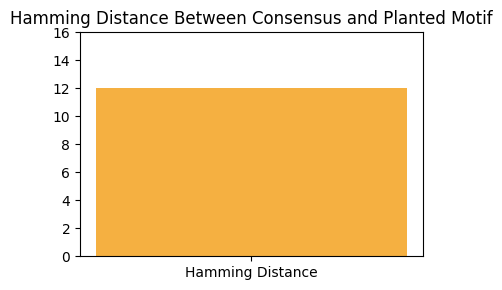

In [ ]:
import random
import numpy as np

# Function to generate random DNA strings
def generate_random_dna(t, N, k, d):
    bases = ['A', 'C', 'G', 'T']
    consensus = ''.join(random.choice(bases) for _ in range(k))
    sequences = []

    for _ in range(t):
        start = random.randint(0, N - k)
        mutated = list(consensus)

        # Introduce up to 'd' mutations
        mutate_indices = random.sample(range(k), d)
        for idx in mutate_indices:
            original = mutated[idx]
            options = [b for b in bases if b != original]
            mutated[idx] = random.choice(options)

        dna = ''.join(random.choice(bases) for _ in range(N))
        mutated_seq = ''.join(mutated)
        dna = dna[:start] + mutated_seq + dna[start + k:]
        sequences.append(dna)

    return sequences, consensus

# Function to calculate profile with pseudocounts
def create_profile_with_pseudocounts(motifs):
    k = len(motifs[0])
    profile = {'A':[1]*k, 'C':[1]*k, 'G':[1]*k, 'T':[1]*k}

    for motif in motifs:
        for i, char in enumerate(motif):
            profile[char][i] += 1

    total = [sum([profile[nuc][i] for nuc in "ACGT"]) for i in range(k)]
    for nuc in "ACGT":
        profile[nuc] = [val/total[i] for i, val in enumerate(profile[nuc])]

    return profile

# Function to calculate probability of a k-mer based on profile
def kmer_probability(kmer, profile):
    prob = 1.0
    for i, char in enumerate(kmer):
        prob *= profile[char][i]
    return prob

# Function to choose a k-mer based on weighted probabilities
def weighted_choice_kmer(dna, k, profile):
    kmers = [dna[i:i+k] for i in range(len(dna) - k + 1)]
    probs = [kmer_probability(kmer, profile) for kmer in kmers]
    total = sum(probs)
    probs = [p/total for p in probs]
    return random.choices(kmers, weights=probs)[0]

# Function to calculate score of motifs
def score_motifs(motifs):
    k = len(motifs[0])
    score = 0
    for i in range(k):
        col = [motif[i] for motif in motifs]
        max_count = max(col.count(base) for base in "ACGT")
        score += (len(motifs) - max_count)
    return score

# Main Gibbs Sampling function
def gibbs_sampler(dna_list, k, N, iterations=1000):
    t = len(dna_list)
    start_indices = [random.randint(0, N-k) for _ in range(t)]
    motifs = [dna_list[i][start_indices[i]:start_indices[i]+k] for i in range(t)]
    best_motifs = motifs[:]
    best_score = score_motifs(motifs)

    for _ in range(iterations):
        i = random.randint(0, t-1)
        reduced_motifs = motifs[:i] + motifs[i+1:]
        profile = create_profile_with_pseudocounts(reduced_motifs)
        new_motif = weighted_choice_kmer(dna_list[i], k, profile)
        motifs[i] = new_motif
        current_score = score_motifs(motifs)

        if current_score < best_score:
            best_score = current_score
            best_motifs = motifs[:]

    return best_motifs, best_score

# Parameters
t = 10
N = 100
k = 15
d = 4

# Generate synthetic data
dna_list, planted_motif = generate_random_dna(t, N, k, d)
print("Planted Motif (Consensus):", planted_motif)

# Run Gibbs Sampling
final_motifs, final_score = gibbs_sampler(dna_list, k, N)
print("Motifs Found by Gibbs Sampling:")
for motif in final_motifs:
    print(motif)
print("Final Score:", final_score)

from collections import Counter

# Function to compute Hamming distance between two strings
def hamming_distance(s1, s2):
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

# Generate consensus from final motifs
def generate_consensus(motifs):
    k = len(motifs[0])
    consensus = ''
    for i in range(k):
        col = [motif[i] for motif in motifs]
        most_common = Counter(col).most_common(1)[0][0]
        consensus += most_common
    return consensus

# Function to calculate accuracy (percentage of matching characters in consensus)
def calculate_accuracy(consensus_found, planted_motif):
    matches = sum(1 for a, b in zip(consensus_found, planted_motif) if a == b)
    return (matches / len(planted_motif)) * 100

# Function to calculate recall
def calculate_recall(consensus_found, dna_list, d):
    count = 0
    for dna in dna_list:
        found = False
        for i in range(len(dna) - len(consensus_found) + 1):
            kmer = dna[i:i+len(consensus_found)]
            if hamming_distance(kmer, consensus_found) <= d:
                found = True
                break
        if found:
            count += 1
    return (count / len(dna_list)) * 100

# Apply the above functions
consensus_found = generate_consensus(final_motifs)
hamming = hamming_distance(consensus_found, planted_motif)
accuracy = calculate_accuracy(consensus_found, planted_motif)
recall = calculate_recall(consensus_found, dna_list, d)

# Output the results
print("\nConsensus Found:", consensus_found)
print("Planted Motif:   ", planted_motif)
print("Hamming Distance:", hamming)
print(f"Accuracy: {accuracy:.2f}%")
print(f"Recall:   {recall:.2f}%")

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Plotting alignment of motifs with consensus
def plot_motif_alignment(motifs, consensus):
    fig, ax = plt.subplots(figsize=(12, 6))
    data = [list(m) for m in motifs]
    data.append(list(consensus))  # Add consensus at the bottom
    sns.heatmap(
        [[ord(c) for c in row] for row in data],
        cbar=False,
        annot=data,
        fmt="s",
        linewidths=0.5,
        linecolor='gray',
        cmap=sns.color_palette("pastel", as_cmap=True),
        xticklabels=list(range(1, len(consensus) + 1)),
        yticklabels=[f"Seq {i+1}" for i in range(len(motifs))] + ["Consensus"],
    )
    plt.title("Motif Alignment with Consensus")
    plt.xlabel("Motif Position")
    plt.ylabel("Sequences")
    plt.tight_layout()
    plt.show()

# 2. Plotting Accuracy and Recall as bar chart
def plot_metrics(accuracy, recall):
    metrics = ['Accuracy', 'Recall']
    values = [accuracy, recall]
    colors = ['#5DADE2', '#58D68D']

    plt.figure(figsize=(6, 4))
    bars = plt.bar(metrics, values, color=colors)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')
    plt.ylim(0, 110)
    plt.title("Accuracy and Recall of Gibbs Sampling")
    plt.ylabel("Percentage")
    plt.tight_layout()
    plt.show()

# 3. Hamming Distance Plot (single-value bar)
def plot_hamming(hamming):
    plt.figure(figsize=(4, 3))
    plt.bar(['Hamming Distance'], [hamming], color='#F5B041')
    plt.ylim(0, k + 1)
    plt.title("Hamming Distance Between Consensus and Planted Motif")
    plt.tight_layout()
    plt.show()

# Call visualization functions
plot_motif_alignment(final_motifs, consensus_found)
plot_metrics(accuracy, recall)
plot_hamming(hamming)



Planted Motif (Consensus): ACAGGCTGATCACAC
Motifs Found by Gibbs Sampling:
TTCACGTCAACACAC
AAGATCCTACCAAAC
CTCCTACAATCATCC
ATCCAGCTCGCGAAC
ATCACTATAAGATAC
ATCTAGCTTTCAGCA
TTAATGCTACCAGAC
ATGTTGCTAACAAGC
ATGATCCAATAAGAC
CTGAGAGAAAGATAC
Final Score: 54

Consensus Found: ATCATGCTAACAAAC
Planted Motif:    ACAGGCTGATCACAC
Hamming Distance: 9
Accuracy: 40.00%
Recall:   100.00%


<ipython-input-57-ab84a13c2a37>:163: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='coolwarm')


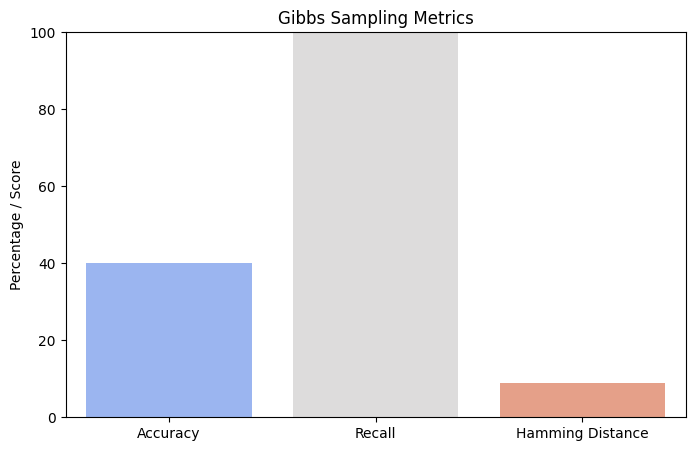

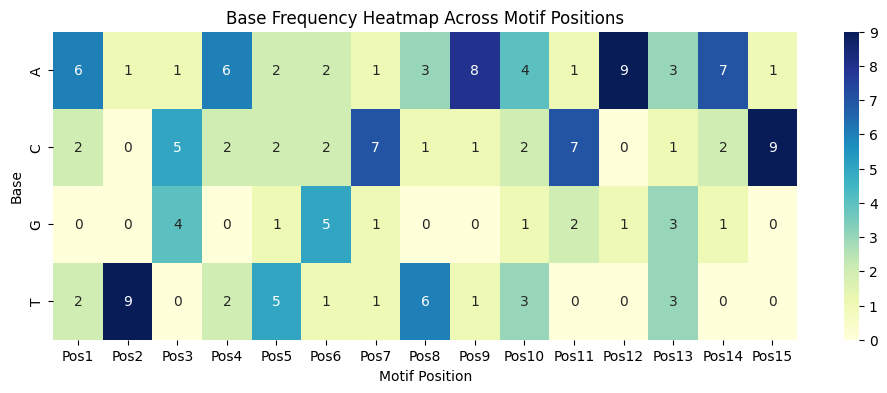

In [ ]:
import random
import numpy as np

# Function to generate random DNA strings
def generate_random_dna(t, N, k, d):
    bases = ['A', 'C', 'G', 'T']
    consensus = ''.join(random.choice(bases) for _ in range(k))
    sequences = []

    for _ in range(t):
        start = random.randint(0, N - k)
        mutated = list(consensus)

        # Introduce up to 'd' mutations
        mutate_indices = random.sample(range(k), d)
        for idx in mutate_indices:
            original = mutated[idx]
            options = [b for b in bases if b != original]
            mutated[idx] = random.choice(options)

        dna = ''.join(random.choice(bases) for _ in range(N))
        mutated_seq = ''.join(mutated)
        dna = dna[:start] + mutated_seq + dna[start + k:]
        sequences.append(dna)

    return sequences, consensus

# Function to calculate profile with pseudocounts
def create_profile_with_pseudocounts(motifs):
    k = len(motifs[0])
    profile = {'A':[1]*k, 'C':[1]*k, 'G':[1]*k, 'T':[1]*k}

    for motif in motifs:
        for i, char in enumerate(motif):
            profile[char][i] += 1

    total = [sum([profile[nuc][i] for nuc in "ACGT"]) for i in range(k)]
    for nuc in "ACGT":
        profile[nuc] = [val/total[i] for i, val in enumerate(profile[nuc])]

    return profile

# Function to calculate probability of a k-mer based on profile
def kmer_probability(kmer, profile):
    prob = 1.0
    for i, char in enumerate(kmer):
        prob *= profile[char][i]
    return prob

# Function to choose a k-mer based on weighted probabilities
def weighted_choice_kmer(dna, k, profile):
    kmers = [dna[i:i+k] for i in range(len(dna) - k + 1)]
    probs = [kmer_probability(kmer, profile) for kmer in kmers]
    total = sum(probs)
    probs = [p/total for p in probs]
    return random.choices(kmers, weights=probs)[0]

# Function to calculate score of motifs
def score_motifs(motifs):
    k = len(motifs[0])
    score = 0
    for i in range(k):
        col = [motif[i] for motif in motifs]
        max_count = max(col.count(base) for base in "ACGT")
        score += (len(motifs) - max_count)
    return score

# Main Gibbs Sampling function
def gibbs_sampler(dna_list, k, N, iterations=1000):
    t = len(dna_list)
    start_indices = [random.randint(0, N-k) for _ in range(t)]
    motifs = [dna_list[i][start_indices[i]:start_indices[i]+k] for i in range(t)]
    best_motifs = motifs[:]
    best_score = score_motifs(motifs)

    for _ in range(iterations):
        i = random.randint(0, t-1)
        reduced_motifs = motifs[:i] + motifs[i+1:]
        profile = create_profile_with_pseudocounts(reduced_motifs)
        new_motif = weighted_choice_kmer(dna_list[i], k, profile)
        motifs[i] = new_motif
        current_score = score_motifs(motifs)

        if current_score < best_score:
            best_score = current_score
            best_motifs = motifs[:]

    return best_motifs, best_score

# Parameters
t = 10
N = 100
k = 15
d = 8

# Generate synthetic data
dna_list, planted_motif = generate_random_dna(t, N, k, d)
print("Planted Motif (Consensus):", planted_motif)

# Run Gibbs Sampling
final_motifs, final_score = gibbs_sampler(dna_list, k, N)
print("Motifs Found by Gibbs Sampling:")
for motif in final_motifs:
    print(motif)
print("Final Score:", final_score)
from collections import Counter

# Function to compute Hamming distance between two strings
def hamming_distance(s1, s2):
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

# Generate consensus from final motifs
def generate_consensus(motifs):
    k = len(motifs[0])
    consensus = ''
    for i in range(k):
        col = [motif[i] for motif in motifs]
        most_common = Counter(col).most_common(1)[0][0]
        consensus += most_common
    return consensus

# Function to calculate accuracy (percentage of matching characters in consensus)
def calculate_accuracy(consensus_found, planted_motif):
    matches = sum(1 for a, b in zip(consensus_found, planted_motif) if a == b)
    return (matches / len(planted_motif)) * 100

# Function to calculate recall
def calculate_recall(consensus_found, dna_list, d):
    count = 0
    for dna in dna_list:
        found = False
        for i in range(len(dna) - len(consensus_found) + 1):
            kmer = dna[i:i+len(consensus_found)]
            if hamming_distance(kmer, consensus_found) <= d:
                found = True
                break
        if found:
            count += 1
    return (count / len(dna_list)) * 100

# Apply the above functions
consensus_found = generate_consensus(final_motifs)
hamming = hamming_distance(consensus_found, planted_motif)
accuracy = calculate_accuracy(consensus_found, planted_motif)
recall = calculate_recall(consensus_found, dna_list, d)

# Output the results
print("\nConsensus Found:", consensus_found)
print("Planted Motif:   ", planted_motif)
print("Hamming Distance:", hamming)
print(f"Accuracy: {accuracy:.2f}%")
print(f"Recall:   {recall:.2f}%")

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# === Bar Plot for Accuracy, Recall, Hamming Distance ===
plt.figure(figsize=(8, 5))
metrics = ['Accuracy', 'Recall', 'Hamming Distance']
values = [accuracy, recall, hamming]

sns.barplot(x=metrics, y=values, palette='coolwarm')
plt.ylim(0, 100)
plt.title('Gibbs Sampling Metrics')
plt.ylabel('Percentage / Score')
plt.show()

# === Heatmap for Base Frequencies at Each Position ===
def motif_frequency_matrix(motifs):
    k = len(motifs[0])
    matrix = {'A':[0]*k, 'C':[0]*k, 'G':[0]*k, 'T':[0]*k}
    for motif in motifs:
        for i, base in enumerate(motif):
            matrix[base][i] += 1
    return matrix

# Convert frequency matrix to DataFrame
freq_matrix = motif_frequency_matrix(final_motifs)
df = pd.DataFrame(freq_matrix)
df = df.T  # Transpose to have bases as rows
df.columns = [f'Pos{i+1}' for i in range(k)]

plt.figure(figsize=(12, 4))
sns.heatmap(df, annot=True, cmap='YlGnBu', cbar=True, fmt="d")
plt.title("Base Frequency Heatmap Across Motif Positions")
plt.ylabel("Base")
plt.xlabel("Motif Position")
plt.show()


Planted Motif (Consensus): GACGTTGACAAAAGC
Motifs Found by Gibbs Sampling:
ACGTTGACAAAATCG
AGGTTGACAAAAGCA
ACGTTGACACAAGCT
ACGTTGACAAATGCG
ACGTTGACAAACGCG
ACGTTGACAAAAGTG
ACTTTGACAAAAGCA
ACTTTGACAAAAGCC
ACGTTGACAAAAGGC
ACTTTGACAAAAGCG
Final Score: 15

Consensus Found:  ACGTTGACAAAAGCG
Planted Motif:    GACGTTGACAAAAGC
Hamming Distance: 11
Accuracy: 26.67%
Recall:   50.00%


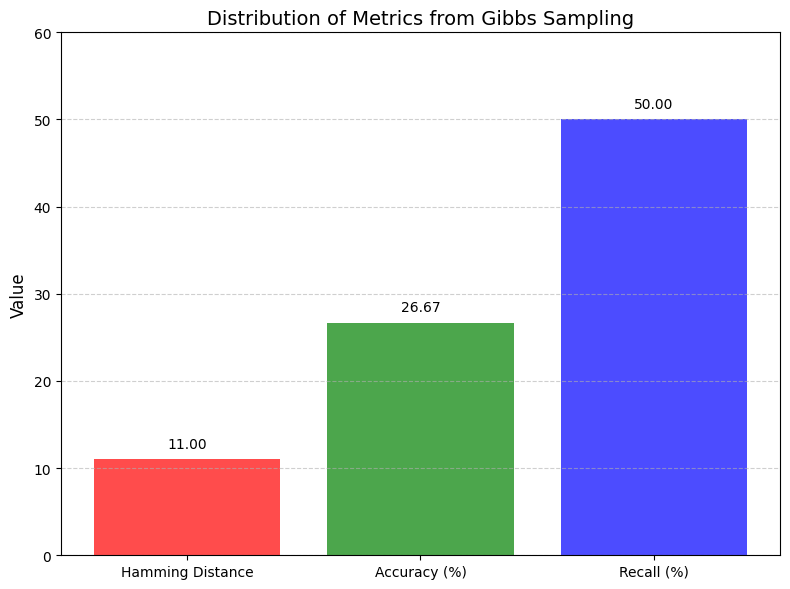

In [ ]:
import random
import numpy as np

# Function to generate random DNA strings
def generate_random_dna(t, N, k, d):
    bases = ['A', 'C', 'G', 'T']
    consensus = ''.join(random.choice(bases) for _ in range(k))
    sequences = []

    for _ in range(t):
        start = random.randint(0, N - k)
        mutated = list(consensus)

        # Introduce up to 'd' mutations
        mutate_indices = random.sample(range(k), d)
        for idx in mutate_indices:
            original = mutated[idx]
            options = [b for b in bases if b != original]
            mutated[idx] = random.choice(options)

        dna = ''.join(random.choice(bases) for _ in range(N))
        mutated_seq = ''.join(mutated)
        dna = dna[:start] + mutated_seq + dna[start + k:]
        sequences.append(dna)

    return sequences, consensus

# Function to calculate profile with pseudocounts
def create_profile_with_pseudocounts(motifs):
    k = len(motifs[0])
    profile = {'A':[1]*k, 'C':[1]*k, 'G':[1]*k, 'T':[1]*k}

    for motif in motifs:
        for i, char in enumerate(motif):
            profile[char][i] += 1

    total = [sum([profile[nuc][i] for nuc in "ACGT"]) for i in range(k)]
    for nuc in "ACGT":
        profile[nuc] = [val/total[i] for i, val in enumerate(profile[nuc])]

    return profile

# Function to calculate probability of a k-mer based on profile
def kmer_probability(kmer, profile):
    prob = 1.0
    for i, char in enumerate(kmer):
        prob *= profile[char][i]
    return prob

# Function to choose a k-mer based on weighted probabilities
def weighted_choice_kmer(dna, k, profile):
    kmers = [dna[i:i+k] for i in range(len(dna) - k + 1)]
    probs = [kmer_probability(kmer, profile) for kmer in kmers]
    total = sum(probs)
    probs = [p/total for p in probs]
    return random.choices(kmers, weights=probs)[0]

# Function to calculate score of motifs
def score_motifs(motifs):
    k = len(motifs[0])
    score = 0
    for i in range(k):
        col = [motif[i] for motif in motifs]
        max_count = max(col.count(base) for base in "ACGT")
        score += (len(motifs) - max_count)
    return score

# Main Gibbs Sampling function
def gibbs_sampler(dna_list, k, N, iterations=1000):
    t = len(dna_list)
    start_indices = [random.randint(0, N-k) for _ in range(t)]
    motifs = [dna_list[i][start_indices[i]:start_indices[i]+k] for i in range(t)]
    best_motifs = motifs[:]
    best_score = score_motifs(motifs)

    for _ in range(iterations):
        i = random.randint(0, t-1)
        reduced_motifs = motifs[:i] + motifs[i+1:]
        profile = create_profile_with_pseudocounts(reduced_motifs)
        new_motif = weighted_choice_kmer(dna_list[i], k, profile)
        motifs[i] = new_motif
        current_score = score_motifs(motifs)

        if current_score < best_score:
            best_score = current_score
            best_motifs = motifs[:]

    return best_motifs, best_score

# Parameters
t = 10
N = 100
k = 15
d = 1
# Generate synthetic data
dna_list, planted_motif = generate_random_dna(t, N, k, d)
print("Planted Motif (Consensus):", planted_motif)

# Run Gibbs Sampling
final_motifs, final_score = gibbs_sampler(dna_list, k, N)
print("Motifs Found by Gibbs Sampling:")
for motif in final_motifs:
    print(motif)
print("Final Score:", final_score)
from collections import Counter

# Function to compute Hamming distance
def hamming_distance(s1, s2):
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

# Generate consensus from final motifs
def generate_consensus(motifs):
    k = len(motifs[0])
    consensus = ''
    for i in range(k):
        col = [motif[i] for motif in motifs]
        most_common = Counter(col).most_common(1)[0][0]
        consensus += most_common
    return consensus

# Calculate accuracy: matching characters between consensus and planted motif
def calculate_accuracy(consensus_found, planted_motif):
    matches = sum(1 for a, b in zip(consensus_found, planted_motif) if a == b)
    return (matches / len(planted_motif)) * 100

# Calculate recall: how many sequences contain a (k,d)-mer matching consensus
def calculate_recall(consensus_found, dna_list, d):
    count = 0
    for dna in dna_list:
        found = False
        for i in range(len(dna) - len(consensus_found) + 1):
            kmer = dna[i:i+len(consensus_found)]
            if hamming_distance(kmer, consensus_found) <= d:
                found = True
                break
        if found:
            count += 1
    return (count / len(dna_list)) * 100

# Compute metrics
consensus_found = generate_consensus(final_motifs)
hamming = hamming_distance(consensus_found, planted_motif)
accuracy = calculate_accuracy(consensus_found, planted_motif)
recall = calculate_recall(consensus_found, dna_list, d)

# Output
print("\nConsensus Found: ", consensus_found)
print("Planted Motif:   ", planted_motif)
print("Hamming Distance:", hamming)
print(f"Accuracy: {accuracy:.2f}%")
print(f"Recall:   {recall:.2f}%")
import matplotlib.pyplot as plt

# Data for plotting
metrics = ['Hamming Distance', 'Accuracy (%)', 'Recall (%)']
values = [hamming, accuracy, recall]

# Plot histogram
plt.figure(figsize=(8, 6))

# Plot each metric as bars
plt.bar(metrics, values, color=['red', 'green', 'blue'], alpha=0.7)

# Add value annotations on top of bars
for i, v in enumerate(values):
    plt.text(i, v + 1, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

# Styling
plt.title('Distribution of Metrics from Gibbs Sampling', fontsize=14)
plt.ylabel('Value', fontsize=12)
plt.ylim(0, max(values) + 10)  # Adjust y-axis to ensure text is visible
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()



Planted Motif (Consensus): GTAGCGCGTGTCTAG
Motifs Found by Gibbs Sampling:
TGTCTCTGGGTACAC
GGAGTCTGTGTCTGT
TTACTTCGGGTCCAA
GGGGCCGGCGTCGAC
AGTCTTGGGGCAAGC
GGACTATAGGTAGGG
GGAATTAGTGTCCGA
ATTCTTCATGCCCGC
AGATTTAGGGCATGC
GGTTTCGTGGTGCGC
Final Score: 57

Consensus Found:  GGACTTTGGGTCCGC
Planted Motif:    GTAGCGCGTGTCTAG
Hamming Distance: 9
Accuracy: 40.00%
Recall:   100.00%


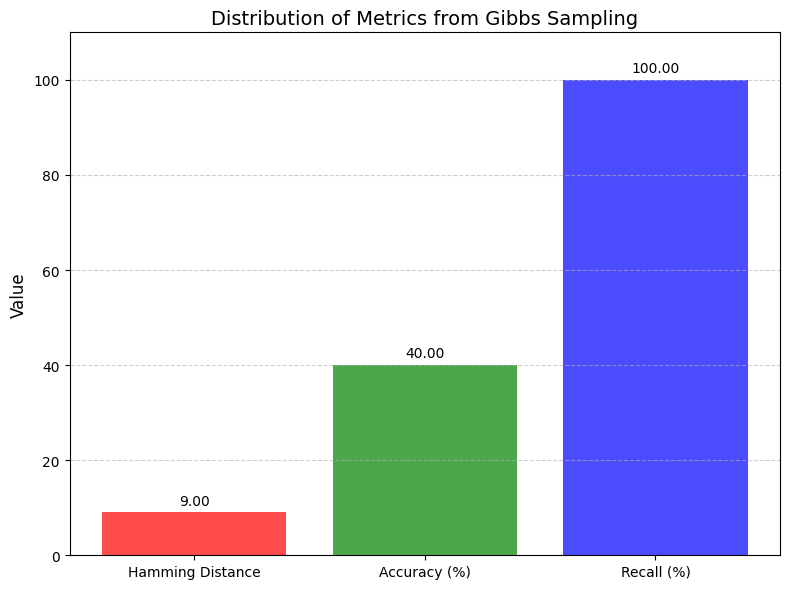

In [ ]:
import random
import numpy as np

# Function to generate random DNA strings
def generate_random_dna(t, N, k, d):
    bases = ['A', 'C', 'G', 'T']
    consensus = ''.join(random.choice(bases) for _ in range(k))
    sequences = []

    for _ in range(t):
        start = random.randint(0, N - k)
        mutated = list(consensus)

        # Introduce up to 'd' mutations
        mutate_indices = random.sample(range(k), d)
        for idx in mutate_indices:
            original = mutated[idx]
            options = [b for b in bases if b != original]
            mutated[idx] = random.choice(options)

        dna = ''.join(random.choice(bases) for _ in range(N))
        mutated_seq = ''.join(mutated)
        dna = dna[:start] + mutated_seq + dna[start + k:]
        sequences.append(dna)

    return sequences, consensus

# Function to calculate profile with pseudocounts
def create_profile_with_pseudocounts(motifs):
    k = len(motifs[0])
    profile = {'A':[1]*k, 'C':[1]*k, 'G':[1]*k, 'T':[1]*k}

    for motif in motifs:
        for i, char in enumerate(motif):
            profile[char][i] += 1

    total = [sum([profile[nuc][i] for nuc in "ACGT"]) for i in range(k)]
    for nuc in "ACGT":
        profile[nuc] = [val/total[i] for i, val in enumerate(profile[nuc])]

    return profile

# Function to calculate probability of a k-mer based on profile
def kmer_probability(kmer, profile):
    prob = 1.0
    for i, char in enumerate(kmer):
        prob *= profile[char][i]
    return prob

# Function to choose a k-mer based on weighted probabilities
def weighted_choice_kmer(dna, k, profile):
    kmers = [dna[i:i+k] for i in range(len(dna) - k + 1)]
    probs = [kmer_probability(kmer, profile) for kmer in kmers]
    total = sum(probs)
    probs = [p/total for p in probs]
    return random.choices(kmers, weights=probs)[0]

# Function to calculate score of motifs
def score_motifs(motifs):
    k = len(motifs[0])
    score = 0
    for i in range(k):
        col = [motif[i] for motif in motifs]
        max_count = max(col.count(base) for base in "ACGT")
        score += (len(motifs) - max_count)
    return score

# Main Gibbs Sampling function
def gibbs_sampler(dna_list, k, N, iterations=1000):
    t = len(dna_list)
    start_indices = [random.randint(0, N-k) for _ in range(t)]
    motifs = [dna_list[i][start_indices[i]:start_indices[i]+k] for i in range(t)]
    best_motifs = motifs[:]
    best_score = score_motifs(motifs)

    for _ in range(iterations):
        i = random.randint(0, t-1)
        reduced_motifs = motifs[:i] + motifs[i+1:]
        profile = create_profile_with_pseudocounts(reduced_motifs)
        new_motif = weighted_choice_kmer(dna_list[i], k, profile)
        motifs[i] = new_motif
        current_score = score_motifs(motifs)

        if current_score < best_score:
            best_score = current_score
            best_motifs = motifs[:]

    return best_motifs, best_score

# Parameters
t = 10
N = 100
k = 15
d = 7

# Generate synthetic data
dna_list, planted_motif = generate_random_dna(t, N, k, d)
print("Planted Motif (Consensus):", planted_motif)

# Run Gibbs Sampling
final_motifs, final_score = gibbs_sampler(dna_list, k, N)
print("Motifs Found by Gibbs Sampling:")
for motif in final_motifs:
    print(motif)
print("Final Score:", final_score)
from collections import Counter

# Function to compute Hamming distance
def hamming_distance(s1, s2):
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

# Generate consensus from final motifs
def generate_consensus(motifs):
    k = len(motifs[0])
    consensus = ''
    for i in range(k):
        col = [motif[i] for motif in motifs]
        most_common = Counter(col).most_common(1)[0][0]
        consensus += most_common
    return consensus

# Calculate accuracy: % of matching bases between consensus and planted motif
def calculate_accuracy(consensus_found, planted_motif):
    matches = sum(1 for a, b in zip(consensus_found, planted_motif) if a == b)
    return (matches / len(planted_motif)) * 100

# Calculate recall: % of DNA strings containing a (k,d)-mer matching consensus
def calculate_recall(consensus_found, dna_list, d):
    count = 0
    k = len(consensus_found)
    for dna in dna_list:
        found = False
        for i in range(len(dna) - k + 1):
            kmer = dna[i:i+k]
            if hamming_distance(kmer, consensus_found) <= d:
                found = True
                break
        if found:
            count += 1
    return (count / len(dna_list)) * 100

# Run metrics
consensus_found = generate_consensus(final_motifs)
hamming = hamming_distance(consensus_found, planted_motif)
accuracy = calculate_accuracy(consensus_found, planted_motif)
recall = calculate_recall(consensus_found, dna_list, d)

# Output
print("\nConsensus Found: ", consensus_found)
print("Planted Motif:   ", planted_motif)
print("Hamming Distance:", hamming)
print(f"Accuracy: {accuracy:.2f}%")
print(f"Recall:   {recall:.2f}%")
import matplotlib.pyplot as plt

# Data for plotting
metrics = ['Hamming Distance', 'Accuracy (%)', 'Recall (%)']
values = [hamming, accuracy, recall]

# Plot histogram
plt.figure(figsize=(8, 6))

# Plot each metric
plt.bar(metrics, values, color=['red', 'green', 'blue'], alpha=0.7)

# Annotate bars with the value on top
for i, v in enumerate(values):
    plt.text(i, v + 1, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

# Styling
plt.title('Distribution of Metrics from Gibbs Sampling', fontsize=14)
plt.ylabel('Value', fontsize=12)
plt.ylim(0, max(values) + 10)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Show plot
plt.tight_layout()
plt.show()



Planted Motif (Consensus): CGACTTCATCGATAA
Motifs Found by Gibbs Sampling:
AACGACATCATCGGT
CACGAGTTCGTCTAT
CACGAGCTCATCGCT
TTCGGCTACAGCGAT
GCCGATTTCATAGAT
GACGACATGATGGAT
GACGAGCTCATCGAC
CTCAACTTCACCGAT
CACGAATTCATTAAT
TCCGAATTCCTCGAT
Final Score: 36

Consensus Found:  CACGACTTCATCGAT
Planted Motif:    CGACTTCATCGATAA
Hamming Distance: 13
Accuracy: 13.33%
Recall:   50.00%


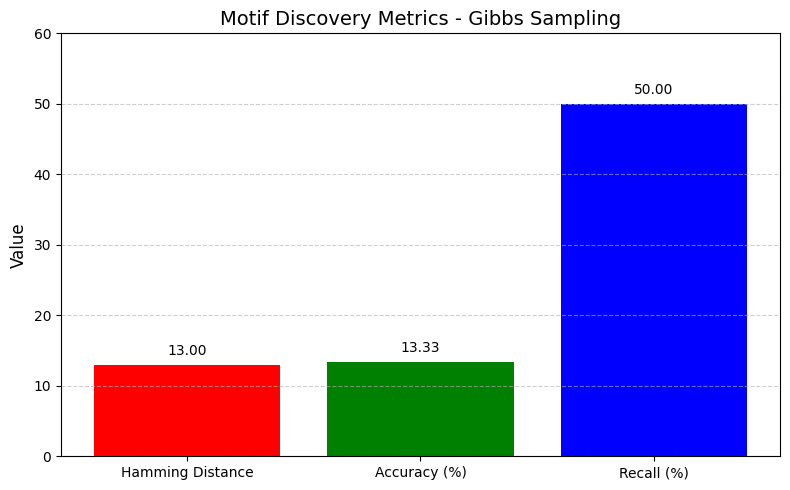

In [ ]:
import random
import numpy as np

# Function to generate random DNA strings
def generate_random_dna(t, N, k, d):
    bases = ['A', 'C', 'G', 'T']
    consensus = ''.join(random.choice(bases) for _ in range(k))
    sequences = []

    for _ in range(t):
        start = random.randint(0, N - k)
        mutated = list(consensus)

        # Introduce up to 'd' mutations
        mutate_indices = random.sample(range(k), d)
        for idx in mutate_indices:
            original = mutated[idx]
            options = [b for b in bases if b != original]
            mutated[idx] = random.choice(options)

        dna = ''.join(random.choice(bases) for _ in range(N))
        mutated_seq = ''.join(mutated)
        dna = dna[:start] + mutated_seq + dna[start + k:]
        sequences.append(dna)

    return sequences, consensus

# Function to calculate profile with pseudocounts
def create_profile_with_pseudocounts(motifs):
    k = len(motifs[0])
    profile = {'A':[1]*k, 'C':[1]*k, 'G':[1]*k, 'T':[1]*k}

    for motif in motifs:
        for i, char in enumerate(motif):
            profile[char][i] += 1

    total = [sum([profile[nuc][i] for nuc in "ACGT"]) for i in range(k)]
    for nuc in "ACGT":
        profile[nuc] = [val/total[i] for i, val in enumerate(profile[nuc])]

    return profile

# Function to calculate probability of a k-mer based on profile
def kmer_probability(kmer, profile):
    prob = 1.0
    for i, char in enumerate(kmer):
        prob *= profile[char][i]
    return prob

# Function to choose a k-mer based on weighted probabilities
def weighted_choice_kmer(dna, k, profile):
    kmers = [dna[i:i+k] for i in range(len(dna) - k + 1)]
    probs = [kmer_probability(kmer, profile) for kmer in kmers]
    total = sum(probs)
    probs = [p/total for p in probs]
    return random.choices(kmers, weights=probs)[0]

# Function to calculate score of motifs
def score_motifs(motifs):
    k = len(motifs[0])
    score = 0
    for i in range(k):
        col = [motif[i] for motif in motifs]
        max_count = max(col.count(base) for base in "ACGT")
        score += (len(motifs) - max_count)
    return score

# Main Gibbs Sampling function
def gibbs_sampler(dna_list, k, N, iterations=1000):
    t = len(dna_list)
    start_indices = [random.randint(0, N-k) for _ in range(t)]
    motifs = [dna_list[i][start_indices[i]:start_indices[i]+k] for i in range(t)]
    best_motifs = motifs[:]
    best_score = score_motifs(motifs)

    for _ in range(iterations):
        i = random.randint(0, t-1)
        reduced_motifs = motifs[:i] + motifs[i+1:]
        profile = create_profile_with_pseudocounts(reduced_motifs)
        new_motif = weighted_choice_kmer(dna_list[i], k, profile)
        motifs[i] = new_motif
        current_score = score_motifs(motifs)

        if current_score < best_score:
            best_score = current_score
            best_motifs = motifs[:]

    return best_motifs, best_score

# Parameters
t = 10
N = 100
k = 15
d = 3

# Generate synthetic data
dna_list, planted_motif = generate_random_dna(t, N, k, d)
print("Planted Motif (Consensus):", planted_motif)

# Run Gibbs Sampling
final_motifs, final_score = gibbs_sampler(dna_list, k, N)
print("Motifs Found by Gibbs Sampling:")
for motif in final_motifs:
    print(motif)
print("Final Score:", final_score)
from collections import Counter

# Function to compute Hamming distance
def hamming_distance(s1, s2):
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

# Generate consensus from final motifs
def generate_consensus(motifs):
    k = len(motifs[0])
    consensus = ''
    for i in range(k):
        col = [motif[i] for motif in motifs]
        most_common = Counter(col).most_common(1)[0][0]
        consensus += most_common
    return consensus

# Accuracy: % of matching characters between consensus and planted motif
def calculate_accuracy(consensus_found, planted_motif):
    matches = sum(1 for a, b in zip(consensus_found, planted_motif) if a == b)
    return (matches / len(planted_motif)) * 100

# Recall: % of sequences that contain a (k,d)-mer matching consensus
def calculate_recall(consensus_found, dna_list, d):
    count = 0
    k = len(consensus_found)
    for dna in dna_list:
        found = False
        for i in range(len(dna) - k + 1):
            kmer = dna[i:i+k]
            if hamming_distance(kmer, consensus_found) <= d:
                found = True
                break
        if found:
            count += 1
    return (count / len(dna_list)) * 100

# Run Metrics
consensus_found = generate_consensus(final_motifs)
hamming = hamming_distance(consensus_found, planted_motif)
accuracy = calculate_accuracy(consensus_found, planted_motif)
recall = calculate_recall(consensus_found, dna_list, d)

# Output
print("\nConsensus Found: ", consensus_found)
print("Planted Motif:   ", planted_motif)
print("Hamming Distance:", hamming)
print(f"Accuracy: {accuracy:.2f}%")
print(f"Recall:   {recall:.2f}%")
import matplotlib.pyplot as plt

# Data for plotting
metrics = ['Hamming Distance', 'Accuracy (%)', 'Recall (%)']
values = [hamming, accuracy, recall]
colors = ['red', 'green', 'blue']

# Create bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color=colors)

# Annotate bars with values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

# Styling
plt.ylim(0, max(values) + 10)
plt.title('Motif Discovery Metrics - Gibbs Sampling', fontsize=14)
plt.ylabel('Value', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Show plot
plt.show()
